In [1]:
import numpy as np
import my_numerical_methods as nm
import my_ode_solvers as os
import matplotlib.pyplot as plt
import my_star_functions as sf
from mpl_toolkits.mplot3d import Axes3D
from my_astro_constants import *
import my_nbody_methods as nbody

from numba import njit

(2, 2)


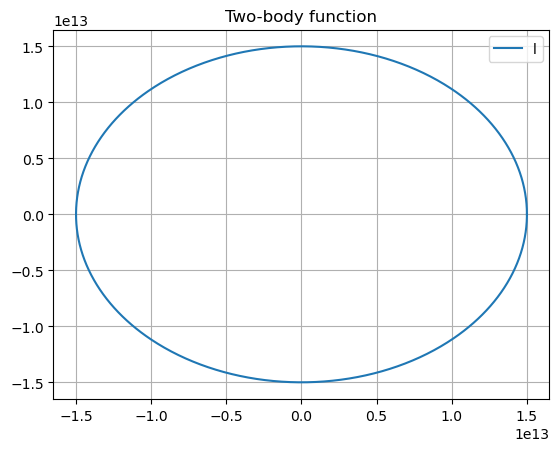

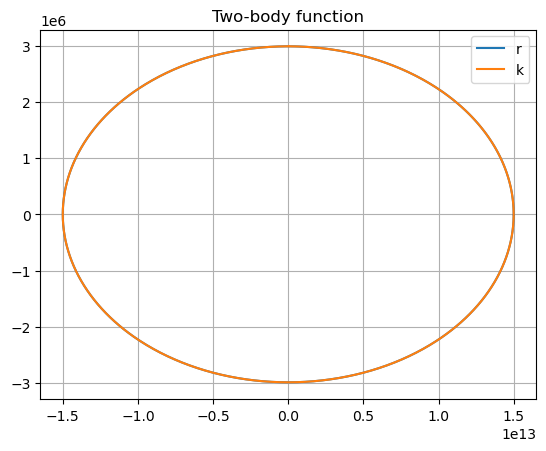

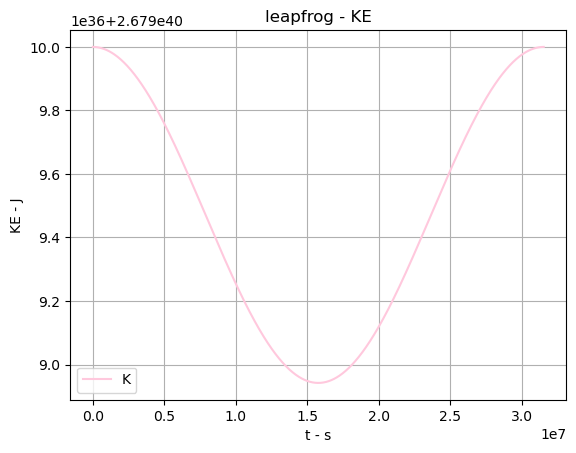

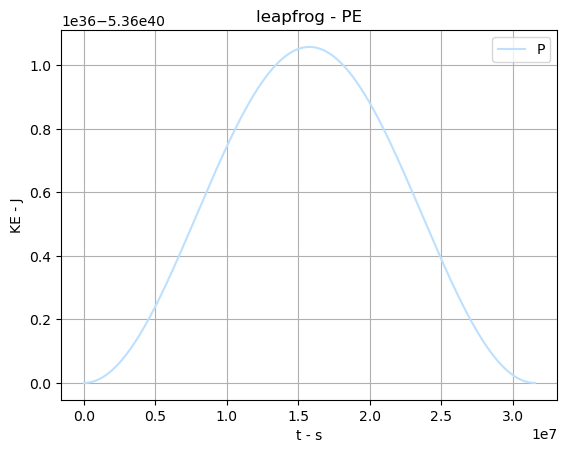

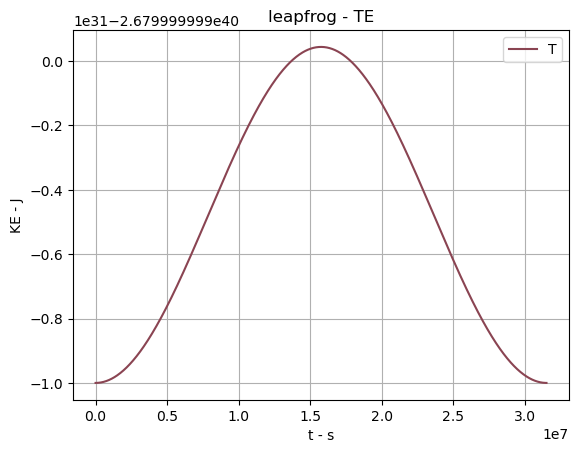

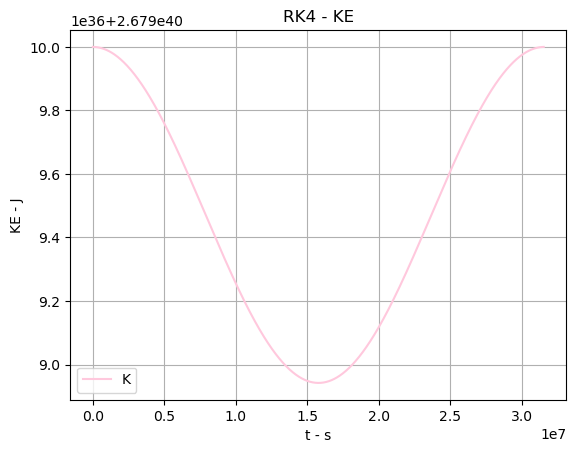

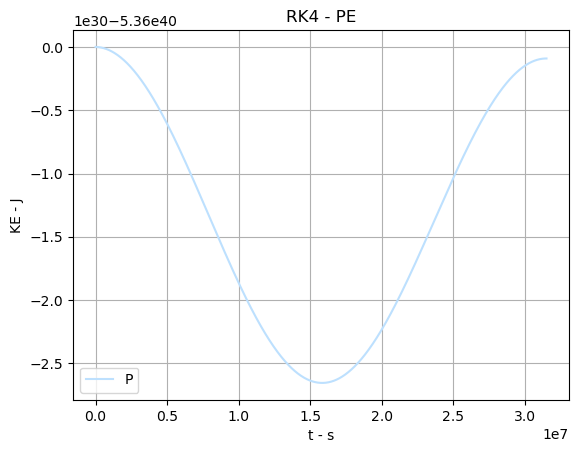

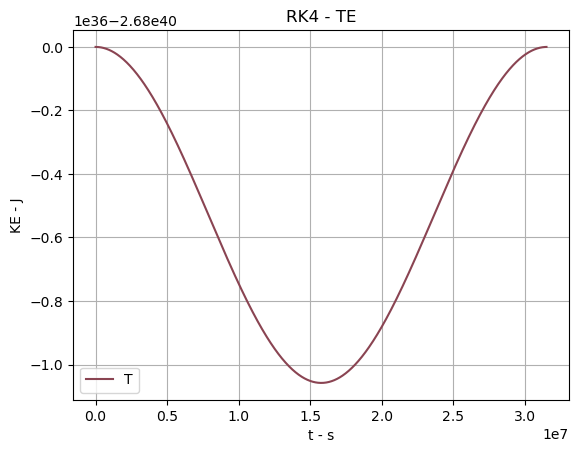

In [2]:
#test case 1: two-body test: sun-earth system
#initial conditions
m1 = earth_mass
m2 = solar_mass
r_cm = np.array([au, 0.0])  # 1 AU along x-axis in cm
v_c = np.array([0.0, nbody.velocity_circ(m2, np.linalg.norm(r_cm))])  # velocity along y-axis

#initial state vector [pos, velo]
y0 = np.array([r_cm, v_c], dtype=float)
print(y0.shape)

#function for n_body as an ode..
def f(t, y):
    position = y[0]
    velocity = y[1]
    
    a = nbody.n_body(m2, np.array([0.0, 0.0]), position)
    return np.array([velocity, a])

#simulation parameters
N = 1000
p = nbody.period(r_cm[0], v_c[1])  # 1 orbital period
dt = p/N

t0 = 0
tN = p
# Create result array
results = np.zeros((N+1, 2, 2))

solver = os.ODE_solver(func=f, state=y0, dt=dt, arr=results)
t, results_lf = solver.leapfrog(y0, t0=0, tN=p, N=N)

positions = results_lf[0]
velocities = results_lf[1]

x = positions[:, 0]
y = positions[:, 1]


#rk4
results_rk4 = np.zeros((N+1, 2))
results_rk4[0] = y0[0]
results_rk4 = solver.integrate(t0=0, tstop=p, integrator='runge-kutta')


x_rk4 = results_rk4[:, 0]
y_rk4 = results_rk4[:, 1]

#plot
sf.plot_func(x, y, label = "leapfrog integration" , Title = "Two-body function")
sf.plot_func(x_rk4, y_rk4, label = "rk4 integration" , Title = "Two-body function")


#energy tests
energies = np.zeros((3, N+1))  # 3 rows: KE, PE, TE
energies_rk4 = np.zeros((3, N))

    
energies = nbody.energy_calc(energies, positions, velocities, m1, m2)
energies_rk4 = nbody.energy_calc(energies_rk4, results_rk4, velocities, m1, m2)
t_rk4 = np.linspace(t0, tN, num = len(energies_rk4[0]))


#plotting energy test.. leapfrog
sf.plot_func(t, energies[0], xlabel = "t - s", ylabel = "KE - J", label = "Kinetic Energy", color = "#ffc8dd", Title = "leapfrog - KE") 
sf.plot_func(t, energies[1], xlabel = "t - s", ylabel = "KE - J", label = "Potential Energy", color = "#bde0fe", Title = "leapfrog - PE")
sf.plot_func(t, energies[2], xlabel = "t - s", ylabel = "KE - J", label = "Total Energy", color ="#8A4452", Title = "leapfrog - TE") 

#rk-4
sf.plot_func(t_rk4, energies_rk4[0], xlabel = "t - s", ylabel = "KE - J", label = "Kinetic Energy", color = "#ffc8dd", Title = "RK4 - KE") 
sf.plot_func(t_rk4, energies_rk4[1], xlabel = "t - s", ylabel = "KE - J", label = "Potential Energy", color = "#bde0fe", Title = "RK4 - PE")
sf.plot_func(t_rk4, energies_rk4[2], xlabel = "t - s", ylabel = "KE - J", label = "Total Energy", color ="#8A4452",Title = "RK4 - TE") 

## Review of the Two-Body Test

1) Which method is more accurate over short timescales?
    After doing some research and reviewing the lectures, Runge-Kutta(4) is more accurate at shorter time scales. It uses a error per step of O(h^4) for total accumulated error. Comparied to local of O(h^5). Found from (https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

   
   It does a weighted average (due to this it might slows things down as this can create drift because the equation is looking at a small fraction of the overall equation to make averages).
   
3) Which method is better at conserving energy over long timescales?

    Leapfrog is better at conserving energy, it takes into consideration the implications certain variables have for their designated equation. It doesn't show artificial damping or growth because it handles the "bigger picture" of equations. However, it will lose some local accuracy to make sure that already determined points are in the same geometric area/path. Due to this, it allows for equations like in Hamiltonian systems to be preserved as it doesn't change the volume/area of the enivorment in phase space, it keeps the parameters of the equation intact.

   
   
5) Explain your findings based on energy conservation and the behavior
of each method.

    Looking at the energy conservation between leapfrog and RK-4 I can see that the range for both of them is the same which means that at least the range for KE was correct. There is some deviation in the PE and TE in terms of scale. I think this was probably how I am recieving the values for leapfrog and rk-4 if you look at the y-axis for leapfrog it is on a scale of 1e13 for the x,y plot while RK-4 for x,y plot is 1E6.

    


352 ms ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.4 s ± 301 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


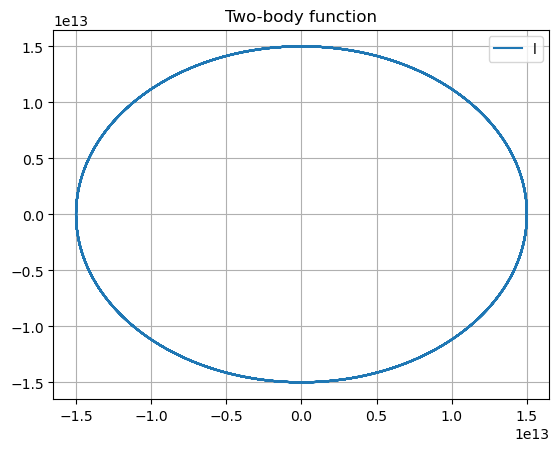

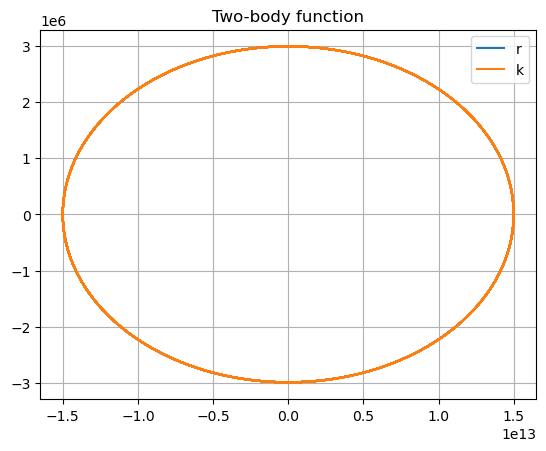

In [3]:
#stability tests
tN = 10*p
N = 10000
dt = tN / N
results_10 = np.zeros((N+1, 2, 2))

#leapfrog
solver = os.ODE_solver(func=f, state=y0, dt=dt, arr=results_10)
t, output = solver.leapfrog(y0, t0=0, tN=tN, N=N)
%timeit t, output = solver.leapfrog(y0, t0=0, tN=tN, N=N)

positions = output[0]
velocities = output[1]

x = positions[:, 0]
y = positions[:, 1]

#rk-4
solver = os.ODE_solver(func=f, state=y0, dt=dt, arr=results_10)
results_rk4 = solver.integrate(t0=0, tstop=tN, integrator='runge-kutta')
%timeit results_rk4 = solver.integrate(t0=0, tstop=tN, integrator='runge-kutta')


x_rk4 = results_rk4[:, 0]
y_rk4 = results_rk4[:, 1]

#plot
sf.plot_func(x, y, label = "leapfrog integration" , Title = "Two-body function")
sf.plot_func(x_rk4, y_rk4, label = "rk4 integration" , Title = "Two-body function")



[[ 0.183893    0.07577262 -0.22807321]
 [-0.51327568 -0.90787393  2.88296473]
 [-0.0198209   0.60562105 -0.1397727 ]
 [-0.14462562  0.36157305 -0.23171536]
 [ 0.34462379  0.95536571  0.43974993]
 [-0.58014246  0.96151252  0.93362324]
 [ 0.14049822 -0.48959222 -0.1930734 ]
 [-0.61981573 -0.06623617 -0.12791859]
 [-0.21907017 -0.24464113 -0.23983496]
 [-0.12247846  0.17581971 -0.23183406]]


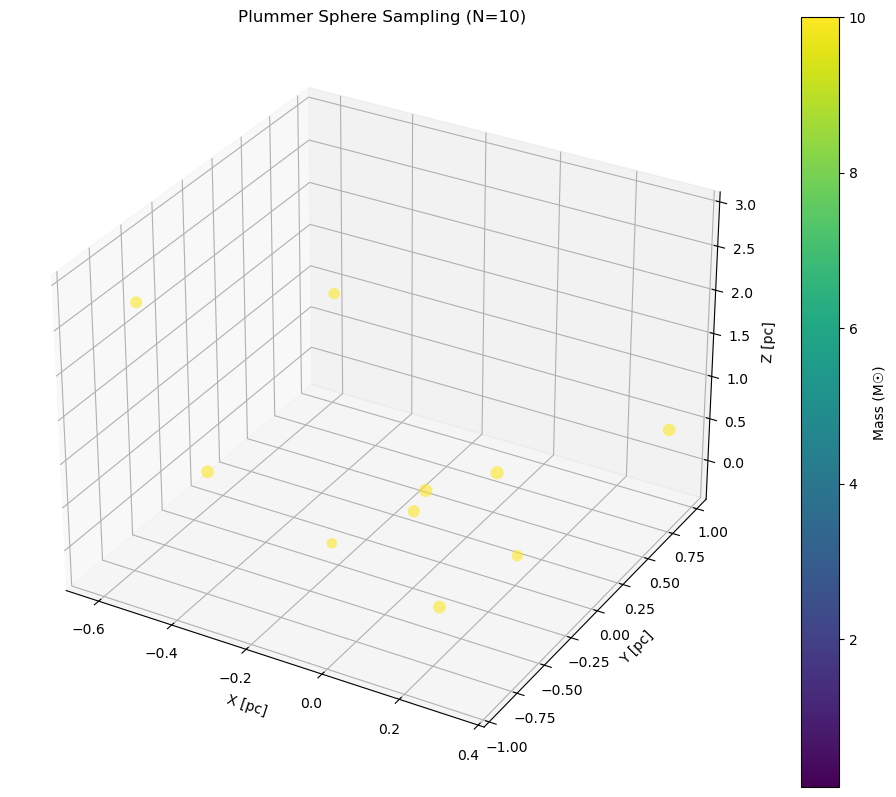

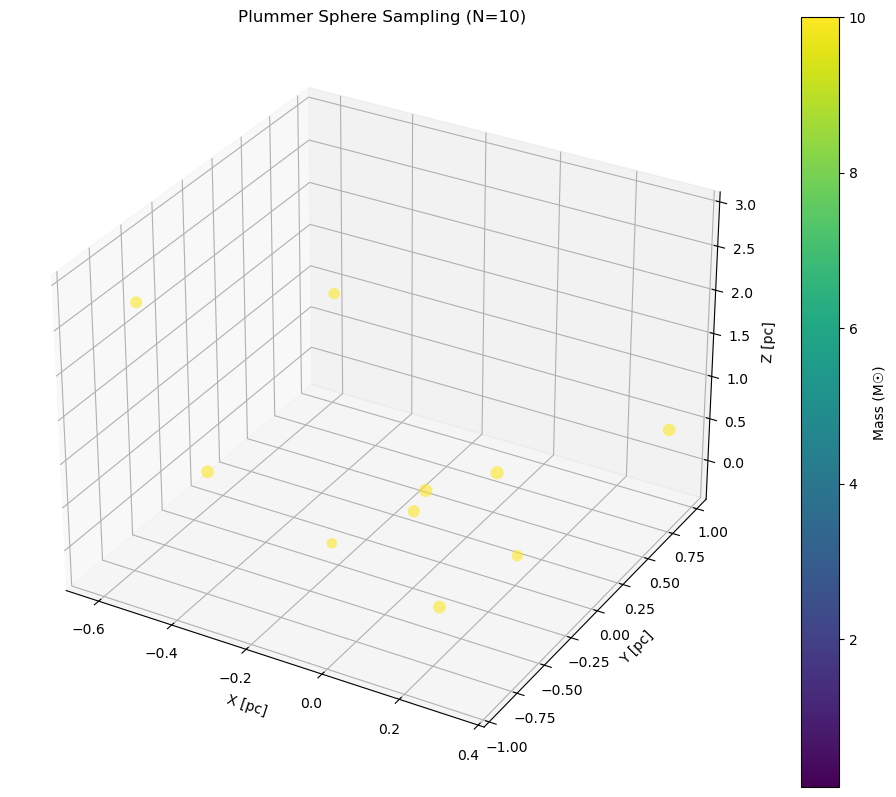

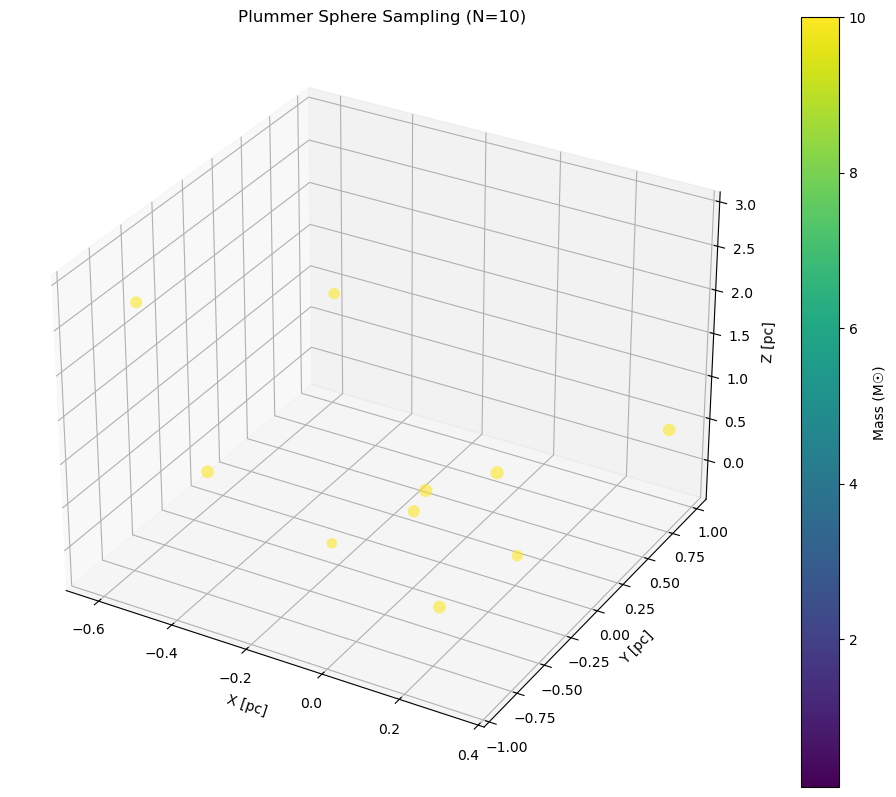

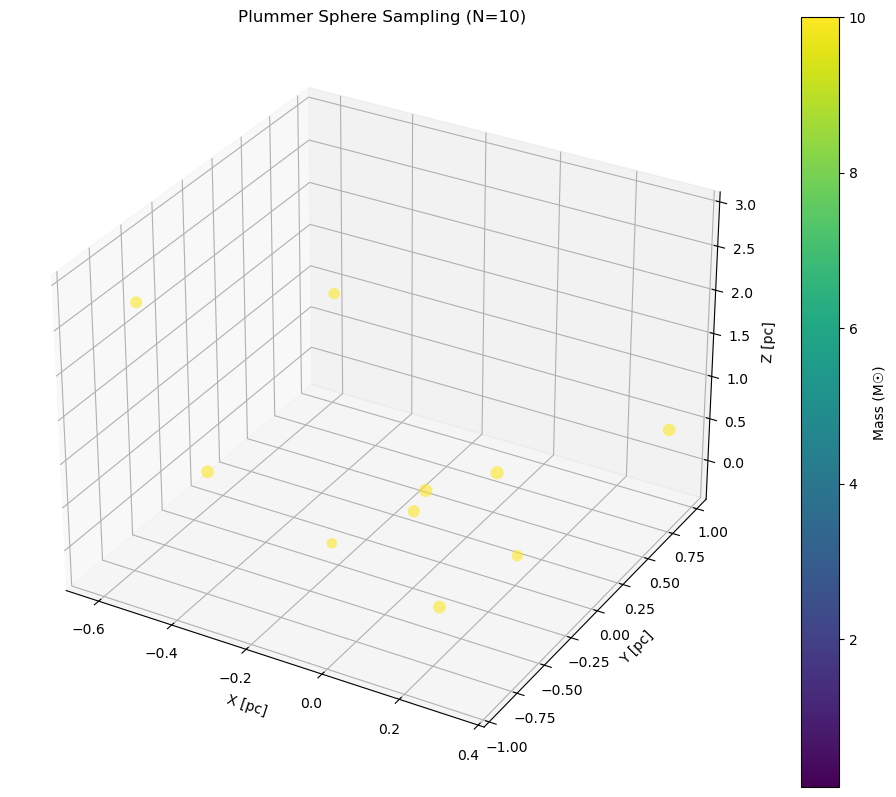

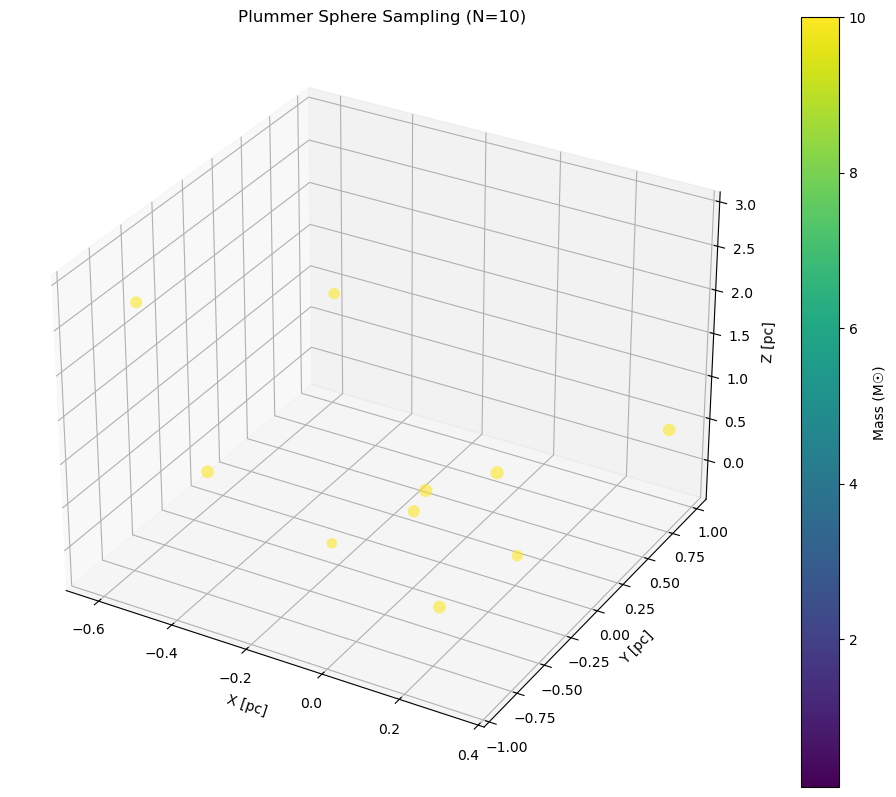

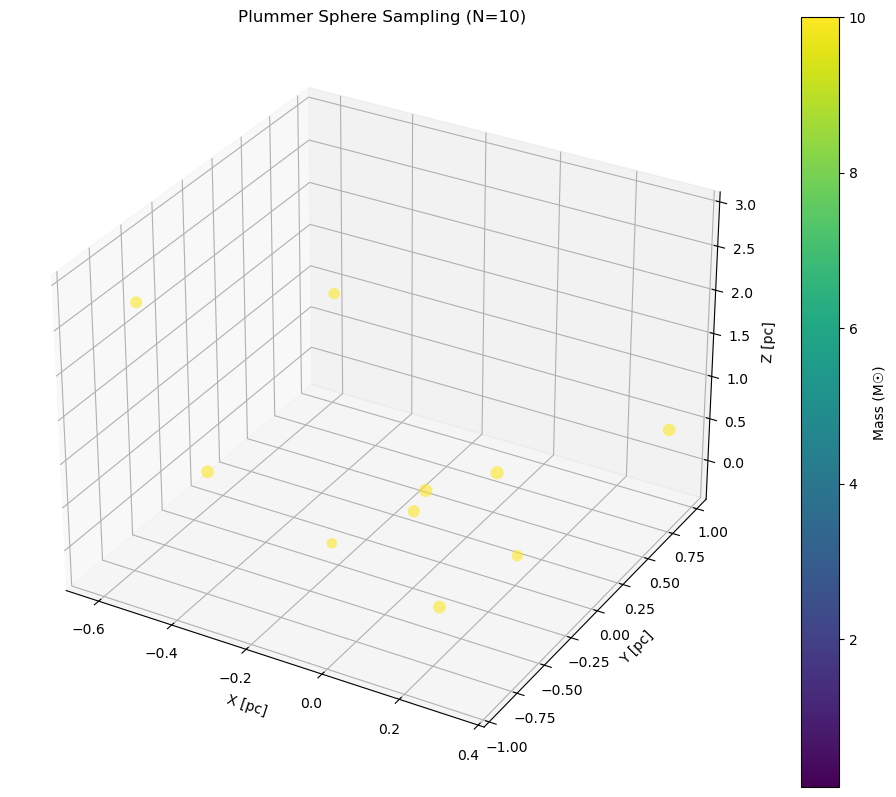

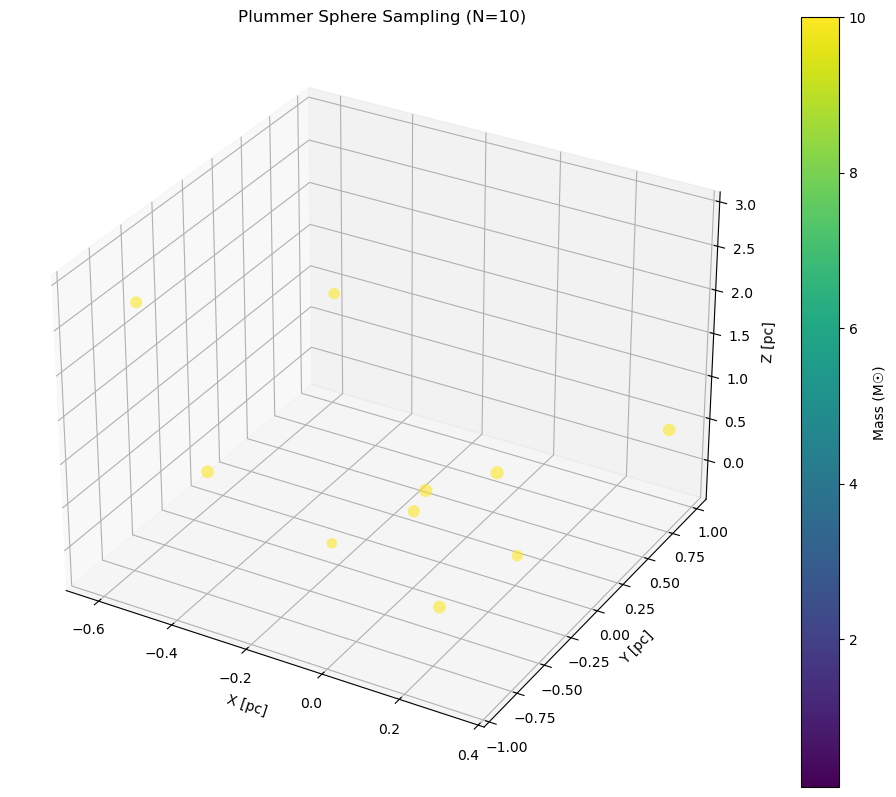

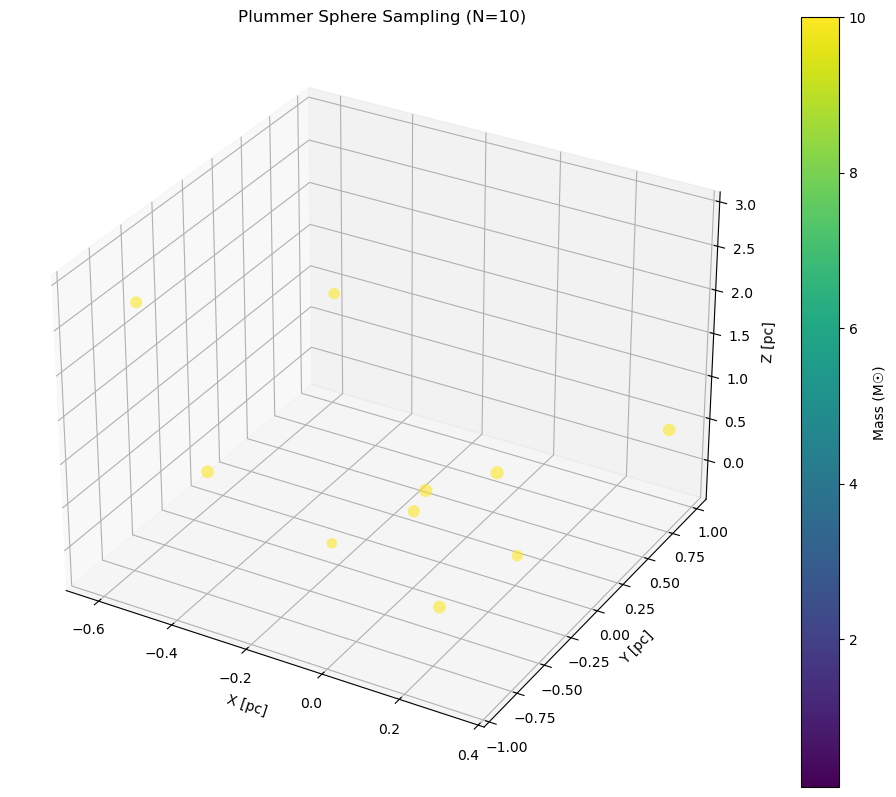

919 ms ± 268 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[[-5.01126252e-01  5.78951032e-01 -7.88342240e-04]
 [-4.99369725e-01  7.36859438e-01  1.68418125e-01]
 [ 5.77818748e-02  2.81421207e-01 -2.40660527e-01]
 [ 8.28155192e-01 -6.51653287e-01  5.62877730e-01]
 [ 9.07017106e-01  3.16994031e-01  3.03007268e-01]
 [-1.83804277e-02 -3.77750403e-01 -2.33805484e-01]
 [ 8.99153800e-01  6.38336902e-01  7.88150578e-01]
 [ 4.61969158e-02  4.31999493e-01 -2.20692401e-01]
 [-2.77740599e-01  5.26940822e-01 -1.46446109e-01]
 [-4.86469740e-02 -4.86698560e-01 -2.01682886e-01]
 [-1.57740229e-01  3.54503208e-01 -2.31992608e-01]
 [ 1.78136407e-01 -6.18866562e-01 -1.12897383e-01]
 [ 3.99930441e-01 -1.87138907e-01 -2.18576188e-01]
 [ 1.74235505e-01  9.21941334e-01  2.55940371e-01]
 [-2.66955121e-01 -1.11476711e+00  1.34790224e+00]
 [ 9.53610782e-01  6.30634559e-01  1.21194426e+00]
 [-1.15562796e-01 -1.09963174e+00  8.06459627e-01]
 [-8.12146792e-01 -6.42375326e-01  5.00033045e-01]
 [-1.07271148e-

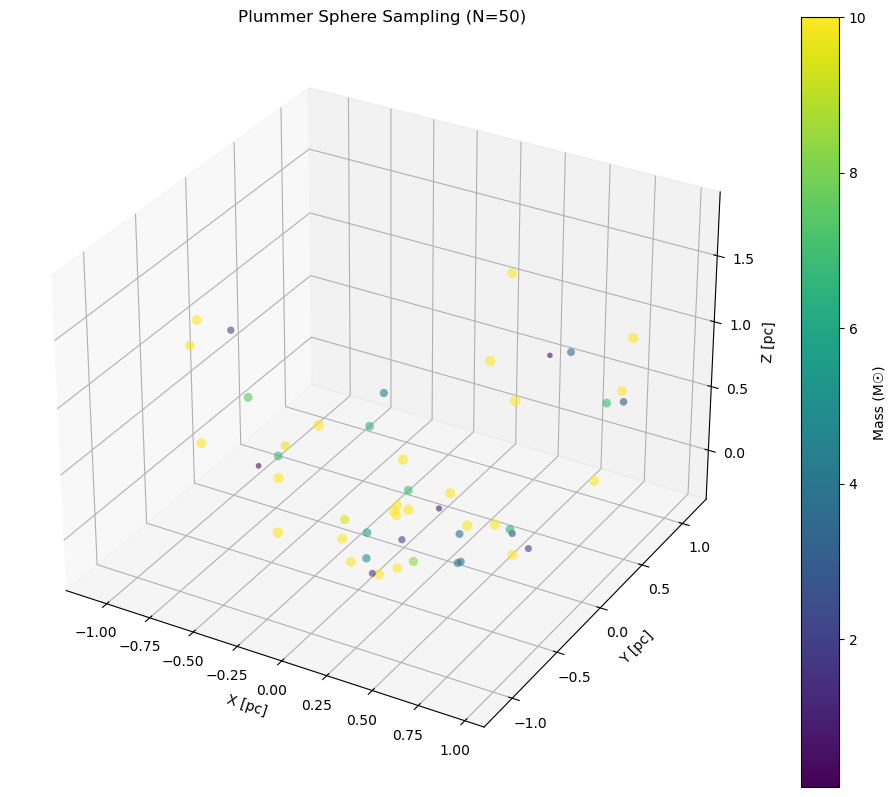

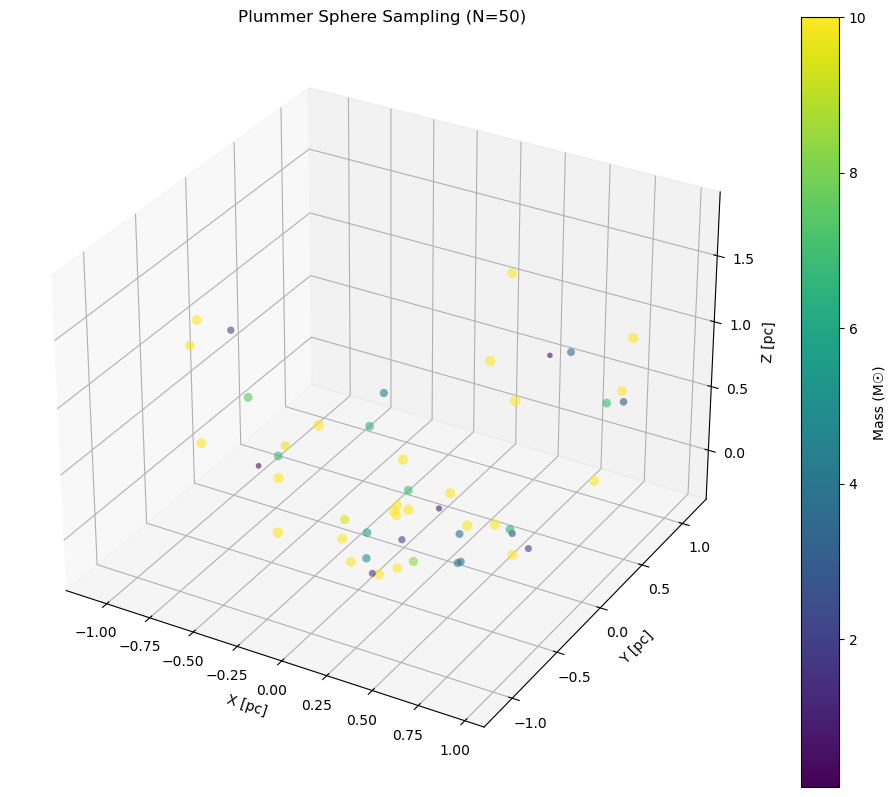

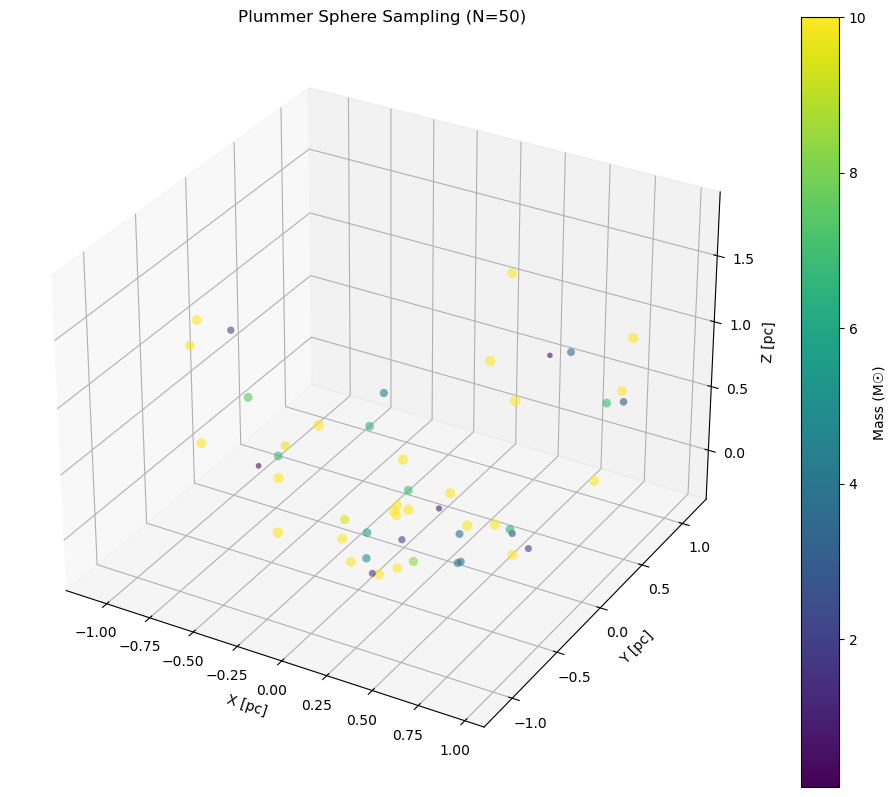

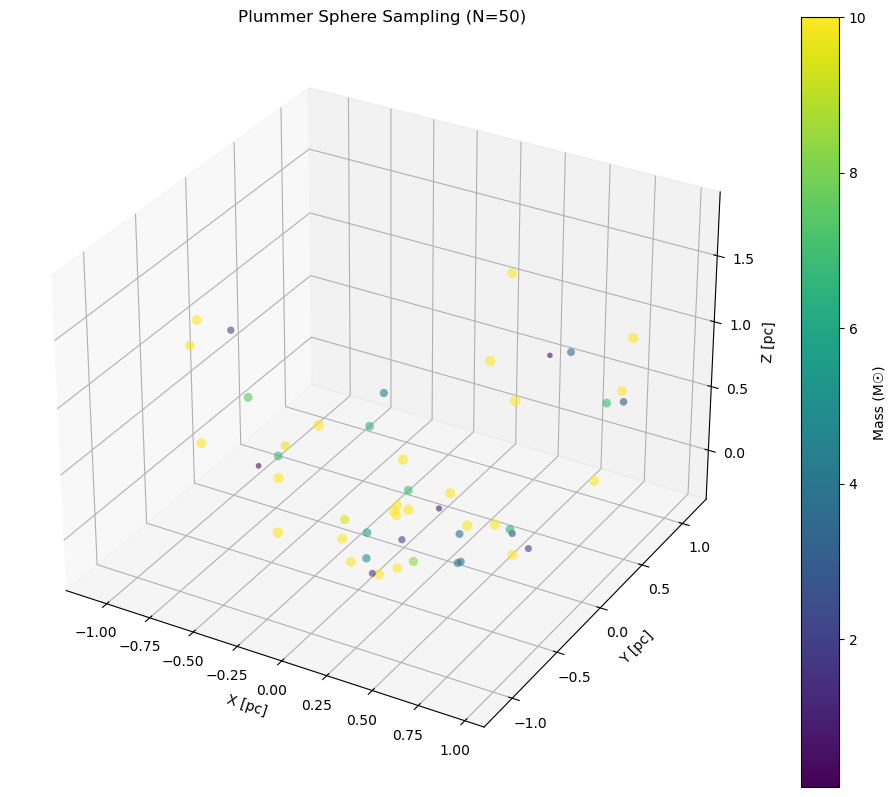

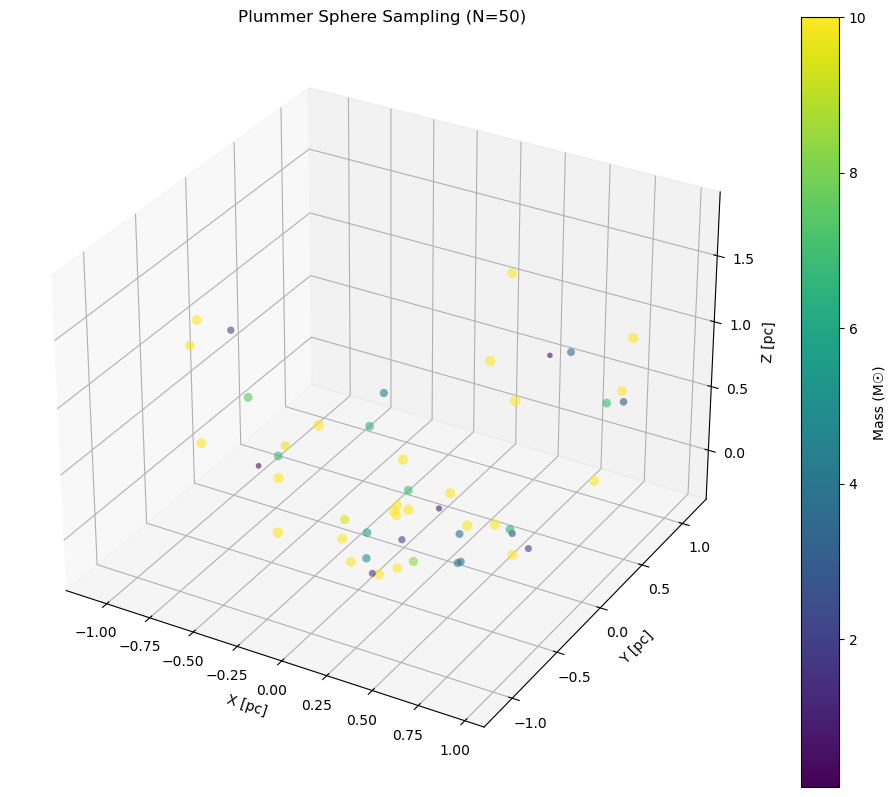

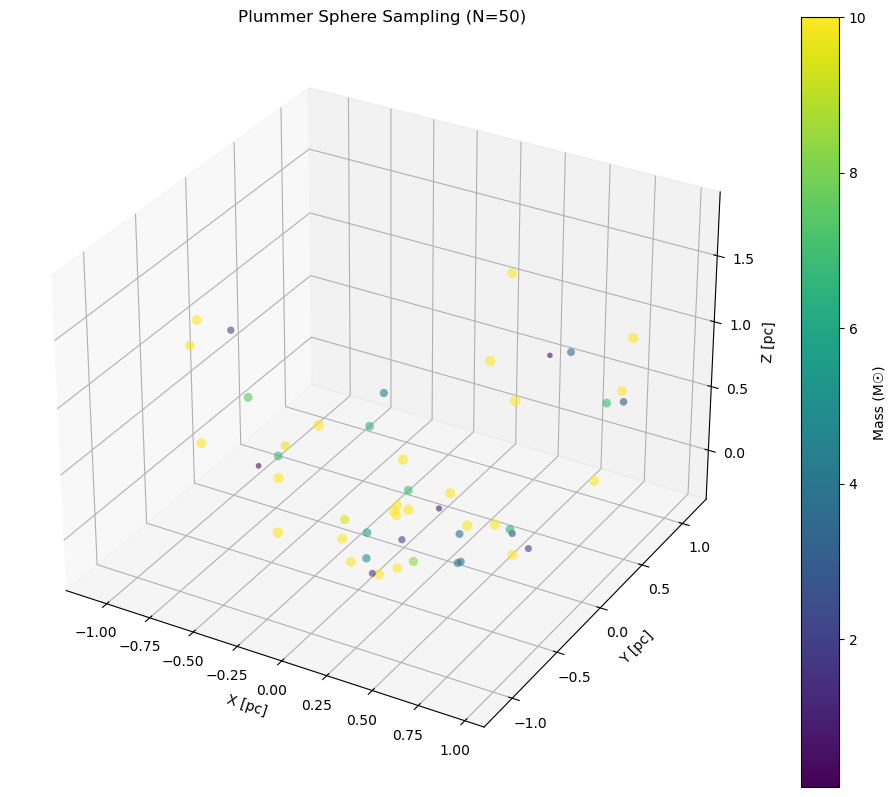

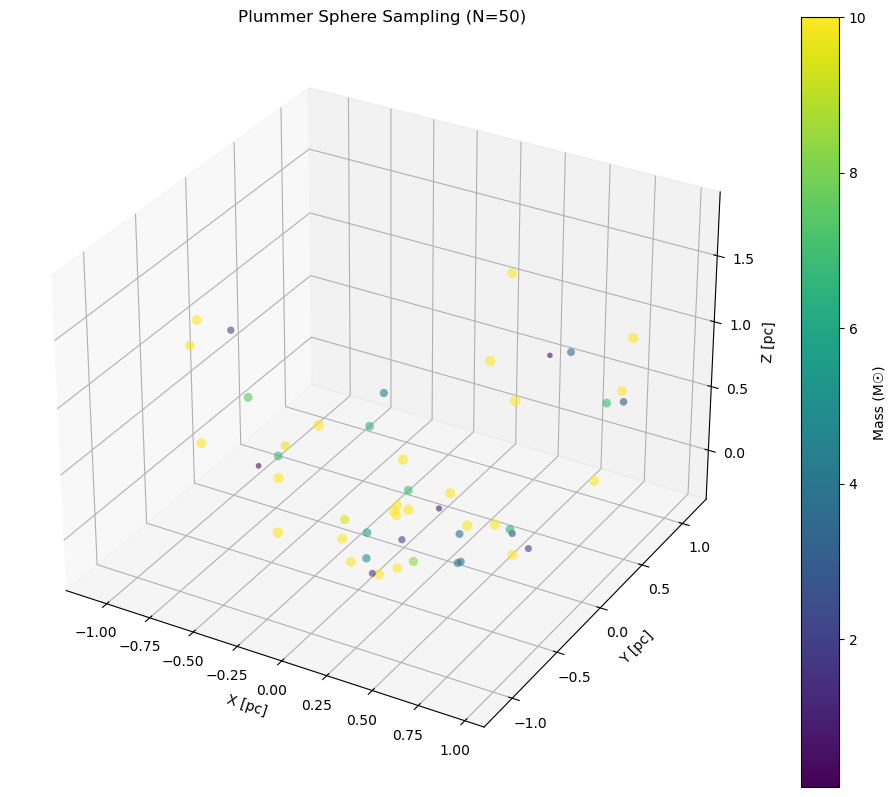

In [ ]:
#monte-carlo sampling
n = [10, 50, 100, 500, 1000]
for i in range(len(n)):
    pos, vel, masses = nbody.sample_plummer(n[i], M_total=500.0)
    %timeit nbody.plot_plummer_sphere(pos, masses, save_path='plummer_sphere.png')

## Simulation & Informal Write Up
1) Your implementation of Monte Carlo sampling from the Plummer
model.

    I implemented the Monte Carlo Sampling from the Plummer Model by defining a function for n_body, distance, plummer density, kinetic energy, potential energy, total energy, and other equations defined.

    I started out (going down from the sample_plummer function) defining the masses 0.1 - 10 as defined in the instructions. From there is needs to be normilized in order to work. Created the u, v dimenisions from 0 -> 1 for n steps.

   After that Spherical coordinates need to be defined for radial distance using the U coordiate, then the theta coordinate, and then the phi.

   After that I converted positions back from spherical to cartesian and calculated the velcotity values using my sample_velocity function.

   For this function I was given pos (in terms of x,y,z) and calculated the radii.
   I then put it in a loop that was based on position, to update the velocity dispersions at each of the radii.

2)
   

## Performance Write Up:
1) Execution Time per simulation for LP vs RK-4
    Looking at what my execution time gave for LP vs RK-4
      - LP: 471 ms ± 45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
      - RK-4: 2.07 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
   I can see that Leapfrog method took longer than RK-4 this makes sense, because based on (10 simulations) leapfrog is not good for small time scales. We can also see that RK-4 has a bigger standard deviation despite it being faster so we know that there is an issue between it.
   
3) Monte-Carlo Simulation
   I did it for a range of N = 10, 50, 100. This was my output (might differ for others)

   - 1.46 s ± 97.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
   - 1.51 s ± 79.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
   - 1.33 s ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
   - 1.32 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
   - 1.38 s ± 63.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

   I think its interesting to note that there was a decrease is run time for N = 100 I'm not sure why this may have happened...
   
